Required Imports

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.image import imread
import os
import skimage
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import DenseNet121
from keras.applications.imagenet_utils import preprocess_input
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

Getting the OCTMNIST dataset from PIP

In [ ]:
!pip install medmnist
from medmnist import OCTMNIST
dataset_train = OCTMNIST(split="train", download=True)
dataset_test = OCTMNIST(split="test", download=True)
dataset_validate = OCTMNIST(split="val", download = True)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116934 sha256=3254057a155fb358d60447ae01eec29306a8e4bee00fd75eefbea17ffdbea095
  Stored in directory: /root/.cache/pip/wheels/90/d4/f7/9404e5db0116bd4d43e5666eaa3e70ab53723e1e3ea40c9a95
Successfully built fire


100%|██████████| 54938180/54938180 [00:44<00:00, 1247707.37it/s]


Using downloaded and verified file: /root/.medmnist/octmnist.npz
Using downloaded and verified file: /root/.medmnist/octmnist.npz


Shape of the dataset-images

In [ ]:
x_train, y_train = dataset_train.imgs, dataset_train.labels
x_test, y_test = dataset_test.imgs, dataset_test.labels
x_val, y_val = dataset_validate.imgs, dataset_validate.labels

print(x_train.shape, y_train.shape, x_train[0].shape)

(97477, 28, 28) (97477, 1) (28, 28)


Resizing the images from 28x28 to 92x92x3

In [ ]:
import cv2
import numpy as np

def preprocess_images(images):
    preprocessed_images = []
    for image in images:
        resized_image = cv2.resize(image, (92, 92))
        rgb_image = cv2.cvtColor(resized_image, cv2.COLOR_GRAY2RGB)
        preprocessed_images.append(rgb_image)
    return np.array(preprocessed_images)

Shape after performing the pre-processing operation

In [ ]:
resized_x_train = preprocess_images(x_train)
resized_x_test = preprocess_images(x_test)
resized_x_val = preprocess_images(x_val)
resized_x_train.shape, resized_x_test.shape, resized_x_val.shape

((97477, 92, 92, 3), (1000, 92, 92, 3), (10832, 92, 92, 3))

Preparing the Base Model - DenseNet121

In [ ]:
base_model = DenseNet121(
    include_top=False,
    weights='imagenet',
    input_shape=(92, 92, 3)
)

#Making all the layers trainable - Model trains from scratch
for layer in base_model.layers:
    layer.trainable = True

#Adding more dense layers to the model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)  

model = Model(inputs=base_model.input, outputs=predictions)

optimizer = Adam(learning_rate=0.00001) 

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#Reduce Learning Rate and Early Stopping callbacks
reduce_learning_rate = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1
)
callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)

29084464/29084464 [==============================] - 0s 0us/step


Fitting the data

In [ ]:
history = model.fit(
    resized_x_train,
    y_train,
    epochs=100,
    validation_data=(resized_x_val, y_val),
    callbacks=[reduce_learning_rate, callbacks]
)

Epoch 1/100
3047/3047 [==============================] - 386s 101ms/step - loss: 0.5767 - accuracy: 0.7960 - val_loss: 0.3908 - val_accuracy: 0.8650 - lr: 1.0000e-05
Epoch 2/100
3047/3047 [==============================] - 289s 95ms/step - loss: 0.3401 - accuracy: 0.8824 - val_loss: 0.3022 - val_accuracy: 0.8961 - lr: 1.0000e-05
Epoch 3/100
3047/3047 [==============================] - 290s 95ms/step - loss: 0.2677 - accuracy: 0.9068 - val_loss: 0.2794 - val_accuracy: 0.9042 - lr: 1.0000e-05
Epoch 4/100
3047/3047 [==============================] - 294s 96ms/step - loss: 0.2151 - accuracy: 0.9252 - val_loss: 0.2723 - val_accuracy: 0.9079 - lr: 1.0000e-05
Epoch 5/100
3047/3047 [==============================] - 292s 96ms/step - loss: 0.1719 - accuracy: 0.9404 - val_loss: 0.2770 - val_accuracy: 0.9130 - lr: 1.0000e-05
Epoch 6/100
3047/3047 [==============================] - 295s 97ms/step - loss: 0.1383 - accuracy: 0.9519 - val_loss: 0.2649 - val_accuracy: 0.9161 - lr: 1.0000e-05
Epoch 7/1

Loss-Accuracy Graphs

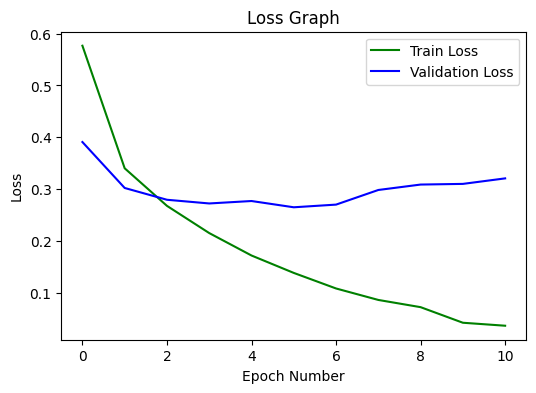

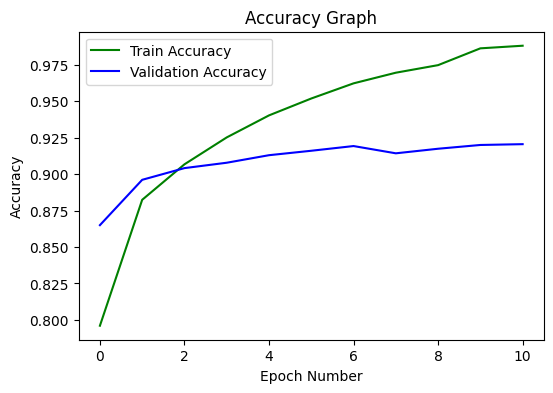

In [ ]:
plt.subplots(figsize=(6,4))
plt.plot(history.epoch, history.history["loss"], color="green", label="Train Loss")
plt.plot(history.epoch, history.history["val_loss"], color="blue",
label="Validation Loss")
plt.xlabel("Epoch Number")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Graph")
plt.show()
plt.subplots(figsize=(6,4))
plt.plot(history.epoch, history.history["accuracy"], color="green",
label="Train Accuracy")
plt.plot(history.epoch, history.history["val_accuracy"], color="blue",
label="Validation Accuracy")
plt.xlabel("Epoch Number")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Graph")
plt.show()

Evaluation results

In [ ]:
model.evaluate(resized_x_test, y_test)

32/32 [==============================] - 2s 52ms/step - loss: 0.8747 - accuracy: 0.7670


[0.8747222423553467, 0.7670000195503235]

Summary of the model used

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 92, 92, 3)]          0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 98, 98, 3)            0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 46, 46, 64)           9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 46, 46, 64)           256       ['conv1/conv[0][0]']      

Saving the trained model for the Ensemble

In [ ]:
model.save("DenseNet121_92.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
